![Add a relevant banner image here](Images/mick-haupt-fDW-BoHRMKE-unsplash_banner.jpg)

# Predicting Song Popularity on the BillBoard Hot 100 List

## Overview

This project seeks to build machine learning models to achieve two things:

1. Predict the highest ranking a song will achieve on the Billboard Hot 100 list.
2. Predict the largest week over week increase in a given song's ranking on the Hot 100 list.

Key Insights:

- A song's genre has a minimal impact on its ranking on the Billboard Hot 100 list.
- Song characteristics such as tempo, danceability, etc. appear to be the strongest drivers of their performance on the Hot 100 list.
- Analyzing music can quickly lead to an overwhelming number of features, so thoughtful and careful data selection is key.

## Business Understanding

The customer of this project is FutureProduct Advisors, a consultancy that helps their customers develop innovative and new consumer products. FutureProduct’s customers are increasingly seeking help from their consultants in go-to-market activities. 

FutureProduct’s consultants can support these go-to-market activities, but the business does not have all the infrastructure needed to support it. Their biggest ask is for a tool to help them find interesting, up-and-coming music to accompany social posts and online ads for go-to-market promotions. 

**Stakeholders**

- FutureProduct Managing Director: oversees their consulting practice and is sponsoring this project.
- FutureProduct Senior Consultants: the actual users of the prospective tool. A small subset of the consultants will pilot the prototype tool.
- My consulting leadership: sponsors of this effort; will provide oversight and technical input of the project as needed.

**Primary Goals**

1.	Build a data tool that can evaluate any song in the Billboard Hot 100 list and make predictions about:
    -	The song’s position on the Hot 100 list 4 weeks in the future
    -	The song’s highest position on the list in the next 6 months
2.	Create a rubric that lists the 3 most important factors for songs’ placement on the Hot 100 list for each hear from 2000 to 2021.


## Data Understanding

Billboard Hot 100 weekly charts (Kaggle): https://www.kaggle.com/datasets/thedevastator/billboard-hot-100-audio-features

I’ve chosen this dataset because it has a direct measurement of song popularity (the Hot 100 list) and because its long history gives significant context to a song’s positioning in a given week.
The features list gives a wide range of song attributes to explore and enables me to determine what features most significantly contribute to a song’s popularity and how that changes over time.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import joblib
from collections import Counter

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

np.random.seed(42)

In [5]:
df_hotlist_all = pd.read_csv('Data/Hot Stuff.csv')
df_features_all = pd.read_csv('Data/Hot 100 Audio Features.csv')

In [6]:
# exploring hotlist df
df_hotlist_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327895 entries, 0 to 327894
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   327895 non-null  int64  
 1   url                     327895 non-null  object 
 2   WeekID                  327895 non-null  object 
 3   Week Position           327895 non-null  int64  
 4   Song                    327895 non-null  object 
 5   Performer               327895 non-null  object 
 6   SongID                  327895 non-null  object 
 7   Instance                327895 non-null  int64  
 8   Previous Week Position  295941 non-null  float64
 9   Peak Position           327895 non-null  int64  
 10  Weeks on Chart          327895 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 27.5+ MB


In [7]:
# exploring features df
df_features_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29503 entries, 0 to 29502
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      29503 non-null  int64  
 1   SongID                     29503 non-null  object 
 2   Performer                  29503 non-null  object 
 3   Song                       29503 non-null  object 
 4   spotify_genre              27903 non-null  object 
 5   spotify_track_id           24397 non-null  object 
 6   spotify_track_preview_url  14491 non-null  object 
 7   spotify_track_duration_ms  24397 non-null  float64
 8   spotify_track_explicit     24397 non-null  object 
 9   spotify_track_album        24391 non-null  object 
 10  danceability               24334 non-null  float64
 11  energy                     24334 non-null  float64
 12  key                        24334 non-null  float64
 13  loudness                   24334 non-null  flo

#### Exploratory Data Analysis

Mean Highest Ranking: 76


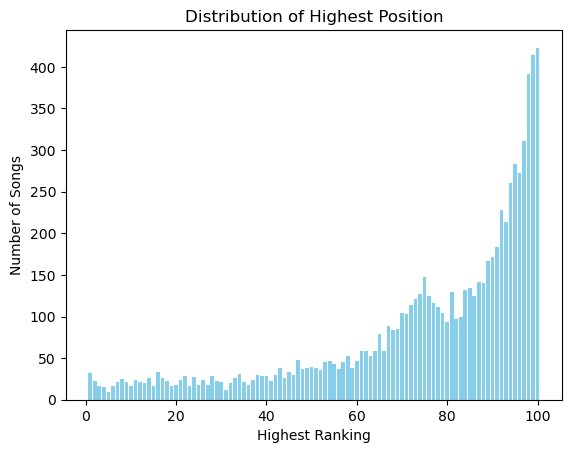

In [104]:
peak_pos_dist = df_clean_withgenre['Max_Peak_Position'].value_counts()
df_peak_pos_dist = pd.DataFrame(peak_pos_dist)
df_peak_pos_dist = df_peak_pos_dist.reset_index()
print(f"Mean Highest Ranking: {df_clean_withgenre['Max_Peak_Position'].mean():.0f}")

plt.bar(df_peak_pos_dist['Max_Peak_Position'], df_peak_pos_dist['count'], color='skyblue')
plt.xlabel('Highest Ranking')
plt.ylabel('Number of Songs')
plt.title('Distribution of Highest Position')
plt.show()

Mean Largest Week over Week Rank Change: 13


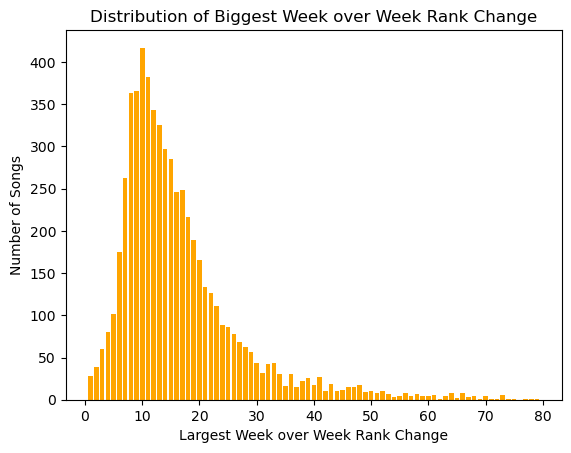

In [103]:
max_rank_change = df_clean_withgenre['Max_Rank_Change'].value_counts()
df_max_rank_change = pd.DataFrame(max_rank_change)
df_max_rank_change = df_max_rank_change.reset_index()
df_max_rank_change = df_max_rank_change[df_max_rank_change['Max_Rank_Change'] > 0]
print(f"Mean Largest Week over Week Rank Change: {df_clean_withgenre['Max_Rank_Change'].mean():.0f}")

plt.bar(df_max_rank_change['Max_Rank_Change'], df_max_rank_change['count'], color='orange')
plt.xlabel('Largest Week over Week Rank Change')
plt.ylabel('Number of Songs')
plt.title('Distribution of Biggest Week over Week Rank Change')
plt.show()

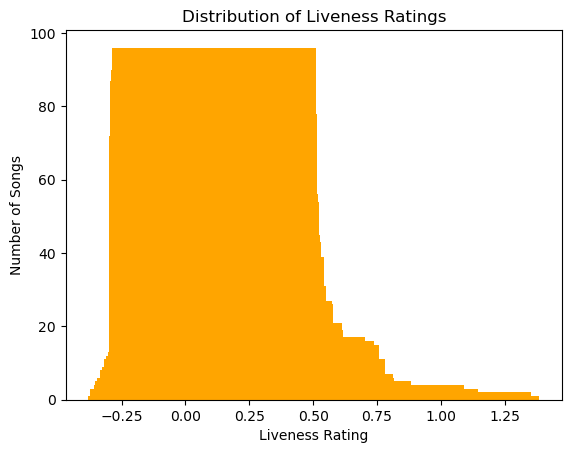

In [98]:
liveness_dist = df_clean_withgenre['liveness'].value_counts()
df_liveness_dist = pd.DataFrame(liveness_dist)
df_liveness_dist = df_liveness_dist.reset_index()

plt.bar(df_liveness_dist['liveness'], df_liveness_dist['count'], color='orange')
plt.xlabel('Liveness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Liveness Ratings')
plt.show()

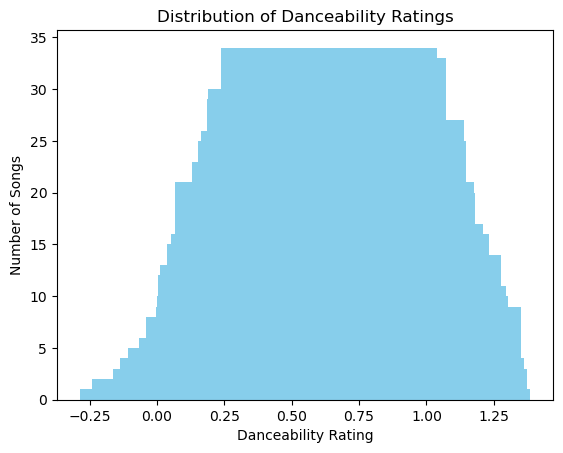

In [99]:
danceability_dist = df_clean_withgenre['danceability'].value_counts()
df_danceability_dist = pd.DataFrame(danceability_dist)
df_danceability_dist = df_danceability_dist.reset_index()

plt.bar(df_danceability_dist['danceability'], df_danceability_dist['count'], color='skyblue')
plt.xlabel('Danceability Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Danceability Ratings')
plt.show()

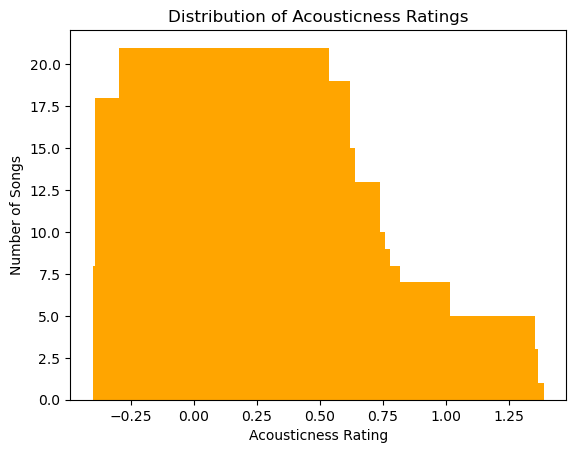

In [100]:
acousticness_dist = df_clean_withgenre['acousticness'].value_counts()
df_acousticness_dist = pd.DataFrame(acousticness_dist)
df_acousticness_dist = df_acousticness_dist.reset_index()

plt.bar(df_acousticness_dist['acousticness'], df_acousticness_dist['count'], color='orange')
plt.xlabel('Acousticness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Acousticness Ratings')
plt.show()

## Data Preparation

### Initial Data Selection

In [8]:
# removing hotlist df attributes that will not be used in cleaning or analysis
df_hotlist_all = df_hotlist_all.drop(['index', 'url', 'Song', 'Performer', 'Instance'], axis=1)
# converting WeekID to datetime
df_hotlist_all['WeekID'] = pd.to_datetime(df_hotlist_all['WeekID'], errors='coerce')
df_hotlist_all = df_hotlist_all.sort_values(by='WeekID')

# creating a new hotlist df with only complete year data from 2000 - 2020, the time period being studied
df_hotlist_2000s = df_hotlist_all.loc[(df_hotlist_all['WeekID'] > '1999-12-31') & (df_hotlist_all['WeekID'] < '2021-01-01')]

# adding a column to calculate the week over week change in rank
df_hotlist_2000s.loc[:, 'Rank_Change'] = df_hotlist_2000s['Week Position'] - df_hotlist_2000s['Previous Week Position']
# replacing NaNs with 0
df_hotlist_2000s.loc[:, 'Rank_Change'] = df_hotlist_2000s['Rank_Change'].fillna(0)

# removing features df attributes that will not be used in cleaning or analysis
df_features_all = df_features_all.drop(['index', 'Performer', 'Song', 'spotify_track_album', 
                                        'spotify_track_id', 'spotify_track_preview_url',  
                                        'spotify_track_explicit', 'spotify_track_popularity'], axis=1)


C:\Users\marha\AppData\Local\Temp\ipykernel_10656\1393120573.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotlist_2000s.loc[:, 'Rank_Change'] = df_hotlist_2000s['Week Position'] - df_hotlist_2000s['Previous Week Position']


In [9]:
# combining the hotlist and features into one dataframe

df_hotlist_and_features_2000s = pd.merge(df_hotlist_2000s, df_features_all, on='SongID', how='left')
df_hotlist_and_features_2000s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112098 entries, 0 to 112097
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   WeekID                     112098 non-null  datetime64[ns]
 1   Week Position              112098 non-null  int64         
 2   SongID                     112098 non-null  object        
 3   Previous Week Position     101571 non-null  float64       
 4   Peak Position              112098 non-null  int64         
 5   Weeks on Chart             112098 non-null  int64         
 6   Rank_Change                112098 non-null  float64       
 7   spotify_genre              108091 non-null  object        
 8   spotify_track_duration_ms  104590 non-null  float64       
 9   danceability               104287 non-null  float64       
 10  energy                     104287 non-null  float64       
 11  key                        104287 non-null  float64 

### Feature Engineering

In [10]:
"""
The dataset has genre in a single column and the entry for each song has a variety of genres listed in that single column. 
This does not allow me to explore genre in a systematic way.
I'll need to break genre out so that each genre has its own column with a 1 or 0 to indicate whether each song is tagged with that genre 
(ending with a one-hot encoded structure).
"""

# generating a df with unique genre names
unique_genres = list(set(
    genre 
    for genre_string in df_hotlist_and_features_2000s['spotify_genre'] 
    if pd.notna(genre_string)
    for genre in ast.literal_eval(genre_string)
))

df_unique_genres = pd.DataFrame(unique_genres, columns=['genre'])

# adding counts of each unique genre name
# Extract all genres (with duplicates) and count them
all_genres_list = []
for genre_string in df_hotlist_and_features_2000s['spotify_genre']:
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        all_genres_list.extend(genre_list)

# Count occurrences
genre_counts = Counter(all_genres_list)

# Map counts to genres dataframe
df_unique_genres['count'] = df_unique_genres['genre'].map(genre_counts)
df_unique_genres = df_unique_genres.sort_values('count', ascending=False)

In [11]:
# writing to csv for easier review of the data
df_unique_genres.to_csv('genre_counts.csv', index=False)

After reviewing the full set of genre counts, I'm only including genres that appear in 100 or more songs (i.e. at least 0.1% of songs).

In [12]:
# loading list of genres with 100 or more instances in df_cleaned
df_genres_100_up = pd.read_csv('genre_counts_100+inst.csv')

# converting df to list
final_genres_list = df_genres_100_up['genre'].tolist()

# manually one-hot encoding each genre

# creating a list of genres and counts
genre_data = []

for genre_string in df_hotlist_and_features_2000s['spotify_genre'] :
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        row_dict = {genre: (1 if genre in genre_list else 0) for genre in final_genres_list} # dict with 1 if genre exists in list, 0 if not
    else:
         row_dict = {genre: 0 for genre in final_genres_list} # 0 of genre does not exist in list
    genre_data.append(row_dict)

# creating a df with the list of dicts
genre_df = pd.DataFrame(genre_data)

# concatenating genre data into df_clean
df_hotlist_and_features_2000s = pd.concat([df_hotlist_and_features_2000s, genre_df], axis=1)


In [13]:
# removing spotify_genre and spot-checking resulting df 
pd.set_option('display.max_columns', None)
df_hotlist_and_features_2000s = df_hotlist_and_features_2000s.drop(['spotify_genre'], axis=1)
df_hotlist_and_features_2000s.head()

,WeekID,Week Position,SongID,Previous Week Position,Peak Position,Weeks on Chart,Rank_Change,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton
0,2000-01-01,69,Deck The HallsSHeDAISY,97.0,69,2,-28.0,229773.0,0.575,0.837,1.0,-7.141,0.0,0.0406,0.0195,0.000009,0.144,0.444,118.827,4.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000-01-01,83,Guerrilla RadioRage Against The Machine,87.0,69,10,-4.0,206200.0,0.599,0.957,11.0,-5.764,1.0,0.1880,0.0129,0.000071,0.155,0.489,103.680,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
# creating new df with most 5 most popular genres by week

# Get all genre column names
genre_start_idx = df_hotlist_and_features_2000s.columns.get_loc('pop')
genre_cols = df_hotlist_and_features_2000s.columns[genre_start_idx:].tolist()

# Group by WeekID and sum the genre columns to get counts
genre_counts = df_hotlist_and_features_2000s.groupby('WeekID')[genre_cols].sum()

# For each week, find the top 5 genres
top_genres = []
for week_id in genre_counts.index:
    # Get the genre counts for this week and sort them
    week_genres = genre_counts.loc[week_id].sort_values(ascending=False)
    
    # Get the top 3 genre names
    top_5 = week_genres.head(5).index.tolist()
    
    # Pad with None if there are fewer than 5 genres
    while len(top_5) < 5:
        top_5.append(None)
    
    top_genres.append({
        'WeekID': week_id,
        'Most_Popular_Genre': top_5[0],
        '2nd_Most_Popular_Genre': top_5[1],
        '3rd_Most_Popular_Genre': top_5[2],
        '4th_Most_Popular_Genre': top_5[3],
        '5th_Most_Popular_Genre': top_5[4]
    })

# Create the new dataframe
df_top_genres = pd.DataFrame(top_genres)


In [15]:
# adding a column to the main df indicating whether each song is in a genre that's in the top 5 genres for a given week

def is_in_top5_genres(row, df_top_genres):
    week = row['WeekID']

    top_genres = df_top_genres[df_top_genres['WeekID'] == week]

    if len(top_genres) == 0:
        return 0
    
    top_5 = [
        top_genres.iloc[0]['Most_Popular_Genre'],
        top_genres.iloc[0]['2nd_Most_Popular_Genre'],
        top_genres.iloc[0]['3rd_Most_Popular_Genre'],
        top_genres.iloc[0]['4th_Most_Popular_Genre'],
        top_genres.iloc[0]['5th_Most_Popular_Genre'],
        ]

    for genre in top_5:
        if genre in row.index and row[genre] == 1:
            return 1
        
        else:
            return 0
        
df_hotlist_and_features_2000s['in_top5_genres'] = df_hotlist_and_features_2000s.apply(
    lambda row: is_in_top5_genres(row, df_top_genres), axis=1
)

In [16]:
# new df with mean score of appearance in top 5 weekly genres
df_mean_genre_match = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['in_top5_genres'].mean()
df_mean_genre_match.rename(columns={'in_top5_genres': 'In_Top5genres_Mean'}, inplace=True)
df_mean_genre_match.set_index('SongID', inplace=True)

# new df with the max weekly rank change for each song 
df_max_rank_change = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['Rank_Change'].max()
df_max_rank_change.rename(columns={'Rank_Change': 'Max_Rank_Change'}, inplace=True)
df_max_rank_change.set_index('SongID', inplace=True)

# new df with the max peak rank for each song 
df_max_peak_pos = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['Peak Position'].max()
df_max_peak_pos.rename(columns={'Peak Position': 'Max_Peak_Position'}, inplace=True)
df_max_peak_pos.set_index('SongID', inplace=True)

# ensuring these new dfs have no null values
df_max_rank_change['Max_Rank_Change'].isna().sum(), df_max_peak_pos['Max_Peak_Position'].isna().sum(), df_mean_genre_match['In_Top5genres_Mean'].isna().sum()

(0, 0, 0)

In [17]:
# adding max peak position to main df
df_2000s_data = df_hotlist_and_features_2000s.join(df_max_peak_pos, on='SongID')

# adding max rank change to main df
df_2000s_data = df_2000s_data.join(df_max_rank_change, on='SongID')

# adding in top5genres mean to main df
df_2000s_data = df_2000s_data.join(df_mean_genre_match, on='SongID')

df_2000s_data.head()

,WeekID,Week Position,SongID,Previous Week Position,Peak Position,Weeks on Chart,Rank_Change,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton,in_top5_genres,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
0,2000-01-01,69,Deck The HallsSHeDAISY,97.0,69,2,-28.0,229773.0,0.575,0.837,1.0,-7.141,0.0,0.0406,0.0195,0.000009,0.144,0.444,118.827,4.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,-8.0,0.0
1,2000-01-01,83,Guerrilla RadioRage Against The Machine,87.0,69,10,-4.0,206200.0,0.599,0.957,11.0,-5.764,1.0,0.1880,0.0129,0.000071,0.155,0.489,103.680,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [18]:
# creating a clean df with genre information
df_clean_withgenre = df_2000s_data.drop(['WeekID', 'Week Position', 'Previous Week Position', 'Peak Position',
                                         'Weeks on Chart', 'Rank_Change', 'in_top5_genres'], axis=1)

# counting duplicates and all rows
df_clean_withgenre.duplicated().sum(), len(df_clean_withgenre)

(103420, 112098)

In [19]:
# removing duplicate rows
df_clean_withgenre = df_clean_withgenre.drop_duplicates()

# checking duplicate rows and rows with missing values
print(f"Total rows: {len(df_clean_withgenre)}")
print(f"Duplicate rows: {df_clean_withgenre.duplicated().sum()}")
print(f"Rows with missing values: {df_clean_withgenre.isna().any(axis=1).sum()}")

Total rows: 8678
Duplicate rows: 0
Rows with missing values: 820


In [20]:
# dropping rows with missing values (unfortunately there is no reliable way to infer or estimate song characteristics)
df_clean_withgenre = df_clean_withgenre.dropna()

# re-checking duplicate rows and rows with missing values
print(f"Total rows: {len(df_clean_withgenre)}")
print(f"Duplicate rows: {df_clean_withgenre.duplicated().sum()}")
print(f"Rows with missing values: {df_clean_withgenre.isna().any(axis=1).sum()}")

Total rows: 7858
Duplicate rows: 0
Rows with missing values: 0


In [21]:
# creating a clean df with no genre
nogenre_cols = ['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                'time_signature', 'Max_Peak_Position', 'Max_Rank_Change', 'In_Top5genres_Mean']
df_clean_nogenre = df_clean_withgenre[nogenre_cols].copy()

I now have two datasets: one containing genre and one without. This will allow me to model this data with and without genre.

In [22]:
df_clean_withgenre = df_clean_withgenre.drop(['SongID'], axis=1)
df_clean_withgenre.describe()

,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
count,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.00000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.00

In [23]:
df_clean_nogenre.describe()

,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
count,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000
mean,225877.547340,0.634195,0.683831,5.258590,-5.955137,0.663019,0.110003,0.173873,0.008682,0.184399,0.506799,122.323709,3.972003,75.775261,12.531815,0.383706
std,46659.091277,0.149508,0.172011,3.589907,2.228035,0.472709,0.110535,0.215344,0.066326,0.140660,0.223494,29.558487,0.273062,24.561479,11.760207,0.466419
min,37013.000000,0.113000,0.031600,0.000000,-23.023000,0.000000,0.022400,0.000003,0.000000,0.020000,0.034900,48.718000,0.000000,1.000000,-8.000000,0.000000
25%,198219.250000,0.533250,0.571000,2.000000,-7.079000,0.000000,0.036200,0.019225,0.000000,0.095900,0.330000,97.943500,4.000000,66.000000,3.000000,0.000000
50%,221798.500000,0.638000,0.704000,5.000000,-5.640000,1.000000,0.057250,0.081900,0.000000,0.128000,0.505000,121.070000,4.000000,84.000000,11.000000,0.000000
75%,248459.500000,0.740000,0.819000,8.000000,-4.406500,1.000000,0.143000,0.247000,0.000017,0.234000,0.679000,142.397250,4.000000,95.000000,17.000000,1.000000
max,992160.000000,0.986000,0.996000,11.000000,0.175000,1.000000,0.951000,0.987000,0.982000,0.986000,0.976000,213.737000,5.000000,100.000000,79.000000,1.000000


### Features and Target Variables

I'm prepping 4 versions for XGBoost and k-NN:

1. Max Peak Position, no genre (nogenre__1 variables)
2. Max Peak Position, with genre (withgenre_1 variables)
3. Max Rank Change, no genre (nogenre_2 variables)
4. Max Rank Change, with genre (withgenre_2 variables)

In [24]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, no genre
X_nogenre_1 = df_clean_nogenre.drop(['Max_Peak_Position'], axis=1)
y_nogenre_1 = df_clean_nogenre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_nogenre_1_train, X_nogenre_1_test, y_nogenre_1_train, y_nogenre_1_test = train_test_split(X_nogenre_1, y_nogenre_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_nogenre_1_train_scaled = scaler.fit_transform(X_nogenre_1_train)
X_nogenre_1_test_scaled = scaler.fit_transform(X_nogenre_1_test)

In [25]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, including genre
X_withgenre_1 = df_clean_withgenre.drop(['Max_Peak_Position'], axis=1)
y_withgenre_1 = df_clean_withgenre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_withgenre_1_train, X_withgenre_1_test, y_withgenre_1_train, y_withgenre_1_test = train_test_split(X_withgenre_1, y_withgenre_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_withgenre_1_train_scaled = scaler.fit_transform(X_withgenre_1_train)
X_withgenre_1_test_scaled = scaler.fit_transform(X_withgenre_1_test)

In [26]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, no genre
X_nogenre_2 = df_clean_nogenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_nogenre_2 = df_clean_nogenre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_nogenre_2_train, X_nogenre_2_test, y_nogenre_2_train, y_nogenre_2_test = train_test_split(X_nogenre_2, y_nogenre_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_nogenre_2_train_scaled = scaler.fit_transform(X_nogenre_2_train)
X_nogenre_2_test_scaled = scaler.fit_transform(X_nogenre_2_test)

In [27]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, including genre
X_withgenre_2 = df_clean_withgenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_withgenre_2 = df_clean_withgenre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_withgenre_2_train, X_withgenre_2_test, y_withgenre_2_train, y_withgenre_2_test = train_test_split(X_withgenre_2, y_withgenre_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_withgenre_2_train_scaled = scaler.fit_transform(X_withgenre_2_train)
X_withgenre_2_test_scaled = scaler.fit_transform(X_withgenre_2_test)

Another 4 versions of the data for the deep learning model

1. Max Peak Position, no genre (nogenre_3 variables)
2. Max Peak Position, with genre (withgenre_3 variables)
3. Max Rank Change, no genre (nogenre_4 variables)
4. Max Rank Change, with genre (withgenre_4 variables)

In [28]:
# features and target for deep learning max_peak_position analysis, no genre
X_nogenre_3 = df_clean_nogenre.drop(['Max_Peak_Position'], axis=1)
y_nogenre_3 = df_clean_nogenre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X_nogenre_3_train, X_nogenre_3_test, y_nogenre_3_train, y_nogenre_3_test = train_test_split(X_nogenre_3, y_nogenre_3, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_nogenre_3_train_final, X_nogenre_3_val, y_nogenre_3_train_final, y_nogenre_3_val = train_test_split(X_nogenre_3_train, y_nogenre_3_train, test_size=0.2, random_state=42)

# normalizing 
scaler.fit(X_nogenre_3_train_final)
X_nogenre_3_train_scaled = scaler.transform(X_nogenre_3_train_final)
X_nogenre_3_val_scaled = scaler.transform(X_nogenre_3_val)
X_nogenre_3_test_scaled = scaler.transform(X_nogenre_3_test)

In [29]:
# features and target for deep learning max_peak_position analysis, including genre
X_withgenre_3 = df_clean_withgenre.drop(['Max_Peak_Position'], axis=1)
y_withgenre_3 = df_clean_withgenre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X_withgenre_3_train, X_withgenre_3_test, y_withgenre_3_train, y_withgenre_3_test = train_test_split(X_withgenre_3, y_withgenre_3, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_withgenre_3_train_final, X_withgenre_3_val, y_withgenre_3_train_final, y_withgenre_3_val = train_test_split(X_withgenre_3_train, y_withgenre_3_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_withgenre_3_train_final)
X_withgenre_3_train_scaled = scaler.transform(X_withgenre_3_train_final)
X_withgenre_3_val_scaled = scaler.transform(X_withgenre_3_val)
X_withgenre_3_test_scaled = scaler.transform(X_withgenre_3_test)

In [30]:
# features and target for deep learning max_rank_change analysis, no genre
X_nogenre_4 = df_clean_nogenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_nogenre_4 = df_clean_nogenre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X_nogenre_4_train, X_nogenre_4_test, y_nogenre_4_train, y_nogenre_4_test = train_test_split(X_nogenre_4, y_nogenre_4, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_nogenre_4_train_final, X_nogenre_4_val, y_nogenre_4_train_final, y_nogenre_4_val = train_test_split(X_nogenre_4_train, y_nogenre_4_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_nogenre_4_train_final)
X_nogenre_4_train_scaled = scaler.transform(X_nogenre_4_train_final)
X_nogenre_4_val_scaled = scaler.transform(X_nogenre_4_val)
X_nogenre_4_test_scaled = scaler.transform(X_nogenre_4_test)

In [31]:
# Prepare features and target for simple deep learning max_rank_change analysis, including genre
X_withgenre_4 = df_clean_withgenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_withgenre_4 = df_clean_withgenre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X_withgenre_4_train, X_withgenre_4_test, y_withgenre_4_train, y_withgenre_4_test = train_test_split(X_withgenre_4, y_withgenre_4, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_withgenre_4_train_final, X_withgenre_4_val, y_withgenre_4_train_final, y_withgenre_4_val = train_test_split(X_withgenre_4_train, y_withgenre_4_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_withgenre_4_train_final)
X_withgenre_4_train_scaled = scaler.transform(X_withgenre_4_train_final)
X_withgenre_4_val_scaled = scaler.transform(X_withgenre_4_val)
X_withgenre_4_test_scaled = scaler.transform(X_withgenre_4_test)

## Analysis

### XGBoost

**XGBoost | Max Peak Position - No Genre**

In [32]:
# XGBoost for max_peak_position, no genre

xgb_maxpeak_nogenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxpeak_nogenre.fit(X_nogenre_1_train_scaled, y_nogenre_1_train)
y_nogenre_1_pred = xgb_maxpeak_nogenre.predict(X_nogenre_1_test_scaled)
y_nogenre_1_pred = np.clip(np.round(y_nogenre_1_pred), 1, 100)

rmse_nogenre_1 = np.sqrt(mean_squared_error(y_nogenre_1_test, y_nogenre_1_pred))
r2_nogenre_1 = r2_score(y_nogenre_1_test, y_nogenre_1_pred)

print(f'RMSE: {rmse_nogenre_1:.3f}')
print(f'R²: {r2_nogenre_1:.3f}')

RMSE: 25.189
R²: 0.009


In [33]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_nogenre_1 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_1.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}


In [34]:
# hyperparameter tuning 2

param_grid2 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15,],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.9, 1.0, 1.1]
}

grid_search_xgb_nogenre_2 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid2,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_2.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.85}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

In [35]:
# hyperparameter tuning 3

param_grid3 = {
    'max_depth': [2],
    'learning_rate': [0.07, 0.1, 0.13],
    'subsample': [0.85],
    'colsample_bytree': [1.0],
}

grid_search_xgb_nogenre_3 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid3,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_3.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_3.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.85}


In [36]:
# Extract best/final model for max_peak_position
best_xgb1_1 = grid_search_xgb_nogenre_3.best_estimator_

# predictions
y_nogenre_1_pred_best = best_xgb1_1.predict(X_nogenre_1_test)
y_nogenre_1_pred_best = np.clip(np.round(y_nogenre_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_nogenre_1_best = np.sqrt(mean_squared_error(y_nogenre_1_test, y_nogenre_1_pred_best))
r2_nogenre_1_best = r2_score(y_nogenre_1_test, y_nogenre_1_pred_best)

print(f'RMSE: {rmse_nogenre_1_best:.3f}')
print(f'R²: {r2_nogenre_1_best:.3f}')

RMSE: 22.851
R²: 0.185


**XGBoost | Max Peak Position - With Genre**

In [37]:
# XGBoost for max_peak_position, with genre

xgb_maxpeak_withgenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxpeak_withgenre.fit(X_withgenre_1_train, y_withgenre_1_train)
y_withgenre_1_pred = xgb_maxpeak_withgenre.predict(X_withgenre_1_test)
y_withgenre_1_pred = np.clip(np.round(y_withgenre_1_pred), 1, 100)

rmse_withgenre_1 = np.sqrt(mean_squared_error(y_withgenre_1_test, y_withgenre_1_pred))
r2_withgenre_1 = r2_score(y_withgenre_1_test, y_withgenre_1_pred)

print(f'RMSE: {rmse_withgenre_1:.3f}')
print(f'R²: {r2_withgenre_1:.3f}')

RMSE: 22.751
R²: 0.192


In [38]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_withgenre_1 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_1.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0}


In [39]:
# hyperparameter tuning 2

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.15, 0.2, 0.25],
    'subsample': [0.9, 1.0, 1.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

grid_search_xgb_withgenre_2 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_2.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 3, 'subsample': 1.0}


In [40]:
# hyperparameter tuning 3

param_grid5 = {
    'max_depth': [3],
    'learning_rate': [0.12, 0.15, 0.17],
    'subsample': [1.0],
    'colsample_bytree': [0.5, 0.6],
}

grid_search_xgb_withgenre_3 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid5,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_3.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_3.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 3, 'subsample': 1.0}


In [41]:
# Extract best/final model 
best_xgb_maxpeak_withgenre = grid_search_xgb_withgenre_3.best_estimator_

# predictions
y_withgenre_1_pred_best = best_xgb_maxpeak_withgenre.predict(X_withgenre_1_test)
y_withgenre_1_pred_best = np.clip(np.round(y_withgenre_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_withgenre_2_best = np.sqrt(mean_squared_error(y_withgenre_1_test, y_withgenre_1_pred_best))
r2_withgenre_2_best = r2_score(y_withgenre_1_test, y_withgenre_1_pred_best)

print(f'RMSE: {rmse_withgenre_2_best:.3f}')
print(f'R²: {r2_withgenre_2_best:.3f}')

RMSE: 21.607
R²: 0.271


**XGBoost | Max Rank Change - No Genre**

In [42]:
# XGBoost for max_rank_change

xgb_maxrank_nogenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxrank_nogenre.fit(X_nogenre_2_train, y_nogenre_2_train)
y_nogenre_2_pred = xgb_maxrank_nogenre.predict(X_nogenre_2_test)
y_nogenre_2_pred = np.clip(np.round(y_nogenre_2_pred), 1, 100)

rmse_maxrank_nogenre_2 = np.sqrt(mean_squared_error(y_nogenre_2_test, y_nogenre_2_pred))
r2_maxrank_nogenre_2 = r2_score(y_nogenre_2_test, y_nogenre_2_pred)

print(f'RMSE: {rmse_maxrank_nogenre_2:.3f}')
print(f'R²: {r2_maxrank_nogenre_2:.3f}')

RMSE: 12.605
R²: -0.097


In [43]:
# hyperparameter tuning 1 for max_rank_change

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_maxrank_nogenre_1 = GridSearchCV(estimator=xgb_maxrank_nogenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_nogenre_1.fit(X_nogenre_2_train, y_nogenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_nogenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


In [44]:
# hyperparameter tuning 2 for max_rank_change

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [1.0, 1.1],
    'colsample_bytree': [1.0, 1.1],
}

grid_search_xgb_maxrank_nogenre_2 = GridSearchCV(estimator=xgb_maxrank_nogenre,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_nogenre_2.fit(X_nogenre_2_train, y_nogenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_nogenre_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 3, 'subsample': 1.0}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File 

In [45]:
# Extract best/final model  for max_rank_change
best_xgb_maxrank_nogenre = grid_search_xgb_maxrank_nogenre_2.best_estimator_

y_nogenre_2_pred_best = best_xgb_maxrank_nogenre.predict(X_nogenre_2_test)
y_nogenre_2_pred_best = np.clip(np.round(y_nogenre_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_maxrank_nogenre_2_best = np.sqrt(mean_squared_error(y_nogenre_2_test, y_nogenre_2_pred_best))
r2_maxrank_nogenre_2_best = r2_score(y_nogenre_2_test, y_nogenre_2_pred_best)

print(f'RMSE: {rmse_maxrank_nogenre_2_best:.3f}')
print(f'R²: {r2_maxrank_nogenre_2_best:.3f}')

RMSE: 11.918
R²: 0.020


**XGBoost | Max Rank Change - With Genre**

In [46]:
# XGBoost for max_rank_change

xgb_maxrank_withgenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxrank_withgenre.fit(X_withgenre_2_train, y_withgenre_2_train)
y_withgenre_2_pred = xgb_maxrank_withgenre.predict(X_withgenre_2_test)
y_withgenre_2_pred = np.clip(np.round(y_withgenre_2_pred), 1, 100)

rmse_maxpeak_withgenre_1 = np.sqrt(mean_squared_error(y_withgenre_2_test, y_withgenre_2_pred))
r2_maxpeak_withgenre_1 = r2_score(y_withgenre_2_test, y_withgenre_2_pred)

print(f'RMSE: {rmse_maxpeak_withgenre_1:.3f}')
print(f'R²: {r2_maxpeak_withgenre_1:.3f}')

RMSE: 12.342
R²: -0.051


In [47]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_maxrank_withgenre_1 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_1.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.8}


In [48]:
# hyperparameter tuning 2

param_grid6 = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [1.0, 1.1],
}

grid_search_xgb_maxrank_withgenre_2 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid6,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_2.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File "

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 6, 'subsample': 0.7}


In [49]:
# hyperparameter tuning 3

param_grid7 = {
    'max_depth': [6],
    'learning_rate': [0.013, 0.015, 0.017],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [1.0],
}

grid_search_xgb_maxrank_withgenre_3 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid7,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_3.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_3.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 6, 'subsample': 0.7}


In [50]:
# Extract best/final model  for max_rank_change
best_xgb_maxrank_withgenre = grid_search_xgb_maxrank_withgenre_3.best_estimator_

y_withgenre_2_pred_best = best_xgb_maxrank_withgenre.predict(X_withgenre_2_test)
y_withgenre_2_pred_best = np.clip(np.round(y_withgenre_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_maxpeak_withgenre_2_best = np.sqrt(mean_squared_error(y_withgenre_2_test, y_withgenre_2_pred_best))
r2_maxpeak_withgenre_2_best = r2_score(y_withgenre_2_test, y_withgenre_2_pred_best)

print(f'RMSE: {rmse_maxpeak_withgenre_2_best:.3f}')
print(f'R²: {r2_maxpeak_withgenre_2_best:.3f}')

RMSE: 11.764
R²: 0.045


#### XGBoost Summary

Using XGBoost, including the genre features slightly improved model performance. However, the Max Rank Change models both had an r<sup>2</sup> value less than 0.001, essentially indicating no fit of the model to the test data. Max Peak Position performed better, but the highest r<sup>2</sup> value was 0.271 so their predictive value is low.

Given the lack of predictive power in these outcomes, I'm shifting focus to the other two techniques.

### k-Nearest Neighbors

**k-Nearest Neighbors | Max Peak Position - No Genre**

In [51]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxpeak_nogenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxpeak_nogenre.fit(X_nogenre_1_train_scaled, y_nogenre_1_train)

# Get best parameters and score
standard_best_params_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_params_
standard_best_score_params_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxpeak_nogenre}")
print(f"Best cross-validation accuracy: {standard_best_score_params_maxpeak_nogenre:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'}
Best cross-validation accuracy: 0.0439


In [52]:
# final model with best parameters
final_model_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_estimator_

# predictions on test set
y_nogenre_1_pred = final_model_maxpeak_nogenre.predict(X_nogenre_1_test_scaled)

# Evaluate the model
accuracy_maxpeak_nogenre_1 = accuracy_score(y_nogenre_1_test, y_nogenre_1_pred)

print(f"Best accuracy: {accuracy_maxpeak_nogenre_1:.4f}")

Best accuracy: 0.0326


**k-Nearest Neighbors | Max Peak Position - With Genre**

In [53]:
# parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxpeak_withgenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxpeak_withgenre.fit(X_withgenre_1_train_scaled, y_withgenre_1_train)

# Get best parameters and score
standard_best_params_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_params_
standard_best_score_params_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxpeak_withgenre}")
print(f"Best cross-validation accuracy: {standard_best_score_params_maxpeak_withgenre:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.0409


In [54]:
# final model with best parameters
final_model_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_estimator_

# predictions on test set
y_withgenre_1_pred = final_model_maxpeak_withgenre.predict(X_withgenre_1_test_scaled)

# Evaluate the model
accuracy_maxpeak_withgenre = accuracy_score(y_withgenre_1_test, y_withgenre_1_pred)

print(f"Best accuracy: {accuracy_maxpeak_withgenre:.4f}")

Best accuracy: 0.0351


**k-Nearest Neighbors | Max Rank Change - No Genre**

In [55]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxrank_nogenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxrank_nogenre.fit(X_nogenre_2_train_scaled, y_nogenre_2_train)

# Get best parameters and score
standard_best_params_maxrank_nogenre = grid_search_maxrank_nogenre.best_params_
standard_best_score_maxrank_nogenre = grid_search_maxrank_nogenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxrank_nogenre}")
print(f"Best cross-validation accuracy: {standard_best_score_maxrank_nogenre:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2350


In [56]:
# final model with best parameters
final_model_maxrank_nogenre = grid_search_maxrank_nogenre.best_estimator_


# Make predictions on test set
y_nogenre_2_pred = final_model_maxrank_nogenre.predict(X_nogenre_2_test_scaled)


# Evaluate the model
accuracy_maxrank_nogenre = accuracy_score(y_nogenre_2_test, y_nogenre_2_pred)

print(f"Best accuracy: {accuracy_maxrank_nogenre:.4f}")

Best accuracy: 0.2163


**k-Nearest Neighbors | Max Rank Change - With Genre**

In [57]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxrank_withgenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxrank_withgenre.fit(X_withgenre_2_train_scaled, y_withgenre_2_train)

# Get best parameters and score
standard_best_params_maxrank_withgenre = grid_search_maxrank_withgenre.best_params_
standard_best_score_maxrank_withgenre = grid_search_maxrank_withgenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxrank_withgenre}")
print(f"Best cross-validation accuracy: {standard_best_score_maxrank_withgenre:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2379


In [58]:
# final model with best parameters
final_model_maxrank_withgenre = grid_search_maxrank_withgenre.best_estimator_


# Make predictions on test set
y_maxrank_withgenre_2_pred = final_model_maxrank_withgenre.predict(X_withgenre_2_test_scaled)


# Evaluate the model
accuracy_maxrank_withgenre = accuracy_score(y_withgenre_2_test, y_maxrank_withgenre_2_pred)

print(f"Best accuracy: {accuracy_maxrank_withgenre:.4f}")

Best accuracy: 0.2173


#### k-NN Summary

The k-NN models performed poorly on the Max Peak Position data, with a maximum accuracy of 0.035. The performance on the Max Rank Change was better, but the maximum accuracy was still just 0.217.

I will not explore k-NN further and instead focus on the deep learning model.

### Deep Learning

**Deep Learning | Max Peak Position - No Genre**

In [59]:
# deep learning model, no regularization or dropout

baseline_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_1 = baseline_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2549.0750 - mae: 41.0085 - mse: 2549.0750 - val_loss: 681.8605 - val_mae: 21.4929 - val_mse: 681.8605
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 673.9514 - mae: 20.7414 - mse: 673.9514 - val_loss: 610.9291 - val_mae: 19.6272 - val_mse: 610.9291
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 622.3873 - mae: 19.7192 - mse: 622.3873 - val_loss: 579.3101 - val_mae: 19.5156 - val_mse: 579.3101
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 594.4716 - mae: 19.2081 - mse: 594.4716 - val_loss: 558.0447 - val_mae: 18.5191 - val_mse: 558.0447
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 572.6750 - mae: 18.7519 - mse: 572.6750 - val_loss: 544.1376 - val_mae: 18.5251 - val_mse: 544.1376
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 559.7896 - mae: 18.5117 - mse: 559.7896 - val_lo

In [60]:
# deep learning model with batch normalization

bnorm_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_nogenre_3_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_1 = bnorm_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 5931.9980 - mae: 73.1585 - mse: 5931.9980 - val_loss: 5702.1641 - val_mae: 71.8102 - val_mse: 5702.1641
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 4786.9932 - mae: 65.2343 - mse: 4786.9932 - val_loss: 3915.7493 - val_mae: 58.6695 - val_mse: 3915.7493
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 3230.7505 - mae: 52.7308 - mse: 3230.7505 - val_loss: 2432.2144 - val_mae: 45.4152 - val_mse: 2432.2144
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 1762.9460 - mae: 38.1016 - mse: 1762.9460 - val_loss: 1257.4479 - val_mae: 31.9857 - val_mse: 1257.4479
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 895.5186 - mae: 26.1274 - mse: 895.5186 - val_loss: 715.8124 - val_mae: 23.3197 - val_mse: 715.8124
Epoch 6/100
158/158 [==============================] - 0s 3ms/step - loss: 594.2126 - mae: 20.2108 - mse: 594

In [61]:
# deep learning model regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2749.8577 - mae: 43.8581 - mse: 2749.8396 - val_loss: 773.7640 - val_mae: 23.4626 - val_mse: 773.7443
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1008.9476 - mae: 26.0395 - mse: 1008.9277 - val_loss: 658.5781 - val_mae: 21.3193 - val_mse: 658.5582
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 941.6064 - mae: 25.0359 - mse: 941.5869 - val_loss: 632.4376 - val_mae: 20.9965 - val_mse: 632.4180
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 883.1840 - mae: 23.9630 - mse: 883.1645 - val_loss: 576.8870 - val_mae: 19.6753 - val_mse: 576.8675
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 831.3453 - mae: 23.3315 - mse: 831.3253 - val_loss: 565.0843 - val_mae: 19.5343 - val_mse: 565.0648
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 828.0806 - mae: 23.2504 - mse: 828.0613 - val_

In [62]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, NO GENRE")

print("\n=== Baseline Model ===")
train_scores3_1 = baseline_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores3_1   = baseline_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores3_1[1]:.4f}, Train MSE: {train_scores3_1[2]:.4f}")
print(f"Val   MAE: {val_scores3_1[1]:.4f}, Val   MSE: {val_scores3_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_1 = bnorm_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_bn3_1   = bnorm_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_1[1]:.4f}, Train MSE: {train_scores_bn3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_1[1]:.4f}, Val   MSE: {val_scores_bn3_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_1 = reg_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, NO GENRE

=== Baseline Model ===
Train MAE: 14.5376, Train MSE: 370.5193
Val   MAE: 18.6078, Val   MSE: 573.3127

=== BatchNorm Model ===
Train MAE: 12.2986, Train MSE: 265.4861
Val   MAE: 18.5169, Val   MSE: 570.5337

=== Regularized Model (L2 + Dropout) ===
Train MAE: 17.0686, Train MSE: 485.9677
Val   MAE: 17.4303, Val   MSE: 477.6276


**Deep Learning | Max Peak Position - With Genre**

In [63]:
# deep learning model, no regularization or dropout

baseline_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_2 = baseline_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2182.0486 - mae: 36.5080 - mse: 2182.0486 - val_loss: 503.8967 - val_mae: 17.5305 - val_mse: 503.8967
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 478.8253 - mae: 16.8225 - mse: 478.8253 - val_loss: 465.0204 - val_mae: 17.0770 - val_mse: 465.0204
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 449.9460 - mae: 16.1127 - mse: 449.9460 - val_loss: 455.7939 - val_mae: 16.6261 - val_mse: 455.7939
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 438.5515 - mae: 15.9133 - mse: 438.5515 - val_loss: 450.6855 - val_mae: 16.4608 - val_mse: 450.6855
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 430.0503 - mae: 15.7003 - mse: 430.0503 - val_loss: 458.0494 - val_mae: 16.9044 - val_mse: 458.0494
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 422.6493 - mae: 15.5085 - mse: 422.6493 - val_lo

In [64]:
# deep learning model with batch normalization

bnorm_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_2 = bnorm_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 5902.7656 - mae: 72.9645 - mse: 5902.7656 - val_loss: 5482.9775 - val_mae: 70.2731 - val_mse: 5482.9775
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 4735.9858 - mae: 64.9505 - mse: 4735.9858 - val_loss: 3955.4973 - val_mae: 59.0720 - val_mse: 3955.4973
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 3195.2764 - mae: 52.6563 - mse: 3195.2764 - val_loss: 2561.8228 - val_mae: 46.8941 - val_mse: 2561.8228
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 1741.4871 - mae: 37.8545 - mse: 1741.4871 - val_loss: 1173.1561 - val_mae: 30.6199 - val_mse: 1173.1561
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 847.8584 - mae: 25.2598 - mse: 847.8584 - val_loss: 636.9456 - val_mae: 21.5026 - val_mse: 636.9456
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 527.5419 - mae: 18.7061 - mse: 527

In [65]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_2 = reg_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2561.1311 - mae: 41.6426 - mse: 2561.1023 - val_loss: 628.7026 - val_mae: 21.0269 - val_mse: 628.6701
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 889.4348 - mae: 24.2678 - mse: 889.4014 - val_loss: 518.2886 - val_mae: 18.5074 - val_mse: 518.2542
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 828.0317 - mae: 23.2819 - mse: 827.9969 - val_loss: 542.7605 - val_mae: 19.4807 - val_mse: 542.7253
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 786.1314 - mae: 22.7033 - mse: 786.0959 - val_loss: 483.8418 - val_mae: 17.8034 - val_mse: 483.8052
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 770.2985 - mae: 22.3831 - mse: 770.2617 - val_loss: 499.8347 - val_mae: 18.2805 - val_mse: 499.7976
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 742.5986 - mae: 21.8940 - mse: 742.5611 - val_lo

In [66]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores3_2 = baseline_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores3_2   = baseline_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores3_2[1]:.4f}, Train MSE: {train_scores3_2[2]:.4f}")
print(f"Val   MAE: {val_scores3_2[1]:.4f}, Val   MSE: {val_scores3_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_2 = bnorm_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores_bn3_2   = bnorm_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_2[1]:.4f}, Train MSE: {train_scores_bn3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_2[1]:.4f}, Val   MSE: {val_scores_bn3_2[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_2 = reg_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores_reg3_2   = reg_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_2[1]:.4f}, Train MSE: {train_scores_reg3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_2[1]:.4f}, Val   MSE: {val_scores_reg3_2[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE

=== Baseline Model ===
Train MAE: 7.4308, Train MSE: 108.3524
Val   MAE: 19.5009, Val   MSE: 680.3669

=== BatchNorm Model ===
Train MAE: 8.1341, Train MSE: 127.4221
Val   MAE: 18.1137, Val   MSE: 578.7206

=== Regularized Model (L2 + Dropout) ===
Train MAE: 14.0596, Train MSE: 361.2997
Val   MAE: 16.4281, Val   MSE: 460.1183


**Deep Learning | Max Rank Change - No Genre**

In [67]:
# deep learning model, no regularization or dropout

baseline_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_1 = baseline_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 173.0271 - mae: 9.5167 - mse: 173.0271 - val_loss: 143.0209 - val_mae: 8.7535 - val_mse: 143.0209
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 140.3795 - mae: 8.5948 - mse: 140.3795 - val_loss: 140.3466 - val_mae: 8.7081 - val_mse: 140.3466
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 138.5347 - mae: 8.5605 - mse: 138.5347 - val_loss: 140.5827 - val_mae: 8.6551 - val_mse: 140.5827
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 137.1174 - mae: 8.5069 - mse: 137.1174 - val_loss: 139.1542 - val_mae: 8.7391 - val_mse: 139.1542
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 136.1940 - mae: 8.5012 - mse: 136.1940 - val_loss: 140.8932 - val_mae: 8.5937 - val_mse: 140.8932
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 135.5046 - mae: 8.4423 - mse: 135.5046 - val_loss: 141.6653 

In [68]:
# deep learning model with batch normalization

bnorm_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_nogenre_4_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_1 = bnorm_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 230.9191 - mae: 10.9147 - mse: 230.9191 - val_loss: 223.2374 - val_mae: 10.8990 - val_mse: 223.2374
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 156.9523 - mae: 8.7983 - mse: 156.9523 - val_loss: 151.2193 - val_mae: 8.7141 - val_mse: 151.2193
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 135.9824 - mae: 8.3225 - mse: 135.9824 - val_loss: 143.6171 - val_mae: 8.5982 - val_mse: 143.6171
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 132.1593 - mae: 8.3107 - mse: 132.1593 - val_loss: 140.5015 - val_mae: 8.6541 - val_mse: 140.5015
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 130.8289 - mae: 8.3266 - mse: 130.8289 - val_loss: 139.0056 - val_mae: 8.6276 - val_mse: 139.0056
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 129.9548 - mae: 8.3062 - mse: 129.9548 - val_loss: 139.653

In [69]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 183.3255 - mae: 9.8088 - mse: 183.3093 - val_loss: 149.9002 - val_mae: 8.7986 - val_mse: 149.8839
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 152.8785 - mae: 8.9936 - mse: 152.8620 - val_loss: 144.4063 - val_mae: 8.6695 - val_mse: 144.3899
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 148.9977 - mae: 8.8929 - mse: 148.9812 - val_loss: 146.3103 - val_mae: 8.6466 - val_mse: 146.2940
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 147.1469 - mae: 8.8556 - mse: 147.1305 - val_loss: 143.1593 - val_mae: 8.6153 - val_mse: 143.1429
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 147.1480 - mae: 8.8299 - mse: 147.1316 - val_loss: 142.7018 - val_mae: 8.5824 - val_mse: 142.6854
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 146.5077 - mae: 8.7636 - mse: 146.4913 - val_loss: 140.3496 

In [70]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, NO GENRE")

print("\n=== Baseline Model ===")
train_scores4_1 = baseline_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores4_1   = baseline_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores4_1[1]:.4f}, Train MSE: {train_scores4_1[2]:.4f}")
print(f"Val   MAE: {val_scores4_1[1]:.4f}, Val   MSE: {val_scores4_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_1 = bnorm_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_bn4_1   = bnorm_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_1 = reg_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, NO GENRE

=== Baseline Model ===
Train MAE: 5.2871, Train MSE: 50.2355
Val   MAE: 10.5364, Val   MSE: 200.4673

=== BatchNorm Model ===
Train MAE: 5.8791, Train MSE: 61.1933
Val   MAE: 9.6900, Val   MSE: 173.9546

=== Regularized Model (L2 + Dropout) ===
Train MAE: 8.0337, Train MSE: 126.7191
Val   MAE: 8.5943, Val   MSE: 144.5637


**Deep Learning | Max Rank Change - With Genre**

In [71]:
# deep learning model, no regularization or dropout

baseline_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_withgenre_4_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_2 = baseline_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 154.9848 - mae: 8.8368 - mse: 154.9848 - val_loss: 138.1960 - val_mae: 8.6468 - val_mse: 138.1960
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 131.0099 - mae: 8.2058 - mse: 131.0099 - val_loss: 138.0397 - val_mae: 8.5955 - val_mse: 138.0397
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 127.7437 - mae: 8.0588 - mse: 127.7437 - val_loss: 138.4746 - val_mae: 8.7850 - val_mse: 138.4746
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 126.1602 - mae: 8.0246 - mse: 126.1602 - val_loss: 139.2280 - val_mae: 8.6638 - val_mse: 139.2280
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 124.8090 - mae: 7.9446 - mse: 124.8090 - val_loss: 139.9446 - val_mae: 8.7577 - val_mse: 139.9446
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 123.9915 - mae: 7.9374 - mse: 123.9915 - val_loss: 138.9343 

In [72]:
# deep learning model with batch normalization

bnorm_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_withgenre_4_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_2 = bnorm_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 227.8885 - mae: 10.7955 - mse: 227.8885 - val_loss: 219.6735 - val_mae: 10.7090 - val_mse: 219.6735
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 150.3945 - mae: 8.4885 - mse: 150.3945 - val_loss: 149.6552 - val_mae: 8.7005 - val_mse: 149.6552
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 129.6347 - mae: 7.9994 - mse: 129.6347 - val_loss: 140.3612 - val_mae: 8.6412 - val_mse: 140.3612
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 125.7956 - mae: 7.9791 - mse: 125.7956 - val_loss: 139.8844 - val_mae: 8.6394 - val_mse: 139.8844
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 123.8026 - mae: 7.8993 - mse: 123.8026 - val_loss: 139.2763 - val_mae: 8.6081 - val_mse: 139.2763
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 121.7854 - mae: 7.8571 - mse: 121.7854 - val_loss: 140.743

In [73]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_withgenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_2 = reg_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 187.8355 - mae: 9.7742 - mse: 187.8106 - val_loss: 144.3890 - val_mae: 8.4949 - val_mse: 144.3627
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 145.8791 - mae: 8.6639 - mse: 145.8523 - val_loss: 138.9953 - val_mae: 8.4993 - val_mse: 138.9680
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 140.9660 - mae: 8.5497 - mse: 140.9386 - val_loss: 145.6071 - val_mae: 8.5743 - val_mse: 145.5797
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 140.9796 - mae: 8.5254 - mse: 140.9519 - val_loss: 144.6924 - val_mae: 8.5317 - val_mse: 144.6647
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 138.4547 - mae: 8.4134 - mse: 138.4270 - val_loss: 142.0000 - val_mae: 8.5083 - val_mse: 141.9722
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 137.6833 - mae: 8.4395 - mse: 137.6553 - val_loss: 148.3880 

In [74]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores4_2 = baseline_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores4_2   = baseline_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores4_2[1]:.4f}, Train MSE: {train_scores4_2[2]:.4f}")
print(f"Val   MAE: {val_scores4_2[1]:.4f}, Val   MSE: {val_scores4_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_2 = bnorm_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores_bn4_2   = bnorm_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_2 = reg_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores_reg4_2   = reg_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_2[1]:.4f}, Train MSE: {train_scores_reg4_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_2[1]:.4f}, Val   MSE: {val_scores_reg4_2[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE

=== Baseline Model ===
Train MAE: 2.3837, Train MSE: 12.2793
Val   MAE: 10.6082, Val   MSE: 219.6110

=== BatchNorm Model ===
Train MAE: 5.8791, Train MSE: 61.1933
Val   MAE: 9.6900, Val   MSE: 173.9546

=== Regularized Model (L2 + Dropout) ===
Train MAE: 7.2130, Train MSE: 98.2133
Val   MAE: 8.7305, Val   MSE: 149.8310


In all versions of the deep learning model, the regularized model has the best combination of low MAE (accuracy) and small difference between training and validation (least overfitting). 

Additionally, the max peak position model with genre data had a lower MAE score. For max rank change, the two models had essentially the same MAE.

Next I'll optimize the regularized, max peak position model with genre and the regularized, max rank change model without genre (in the interest of maximizing model efficiency).

**Deep Learning | Optimizing Regularized Models**

Max Peak Position (regularized, with genre)

In [75]:
# adding a layer

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_nogenre_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_1.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2550.5391 - mae: 41.4492 - mse: 2550.5146 - val_loss: 740.9598 - val_mae: 23.0691 - val_mse: 740.9349
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1155.8129 - mae: 27.9100 - mse: 1155.7880 - val_loss: 702.9857 - val_mae: 22.6556 - val_mse: 702.9611
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 1036.5747 - mae: 26.2058 - mse: 1036.5500 - val_loss: 679.6901 - val_mae: 22.3479 - val_mse: 679.6654
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 932.4151 - mae: 24.7938 - mse: 932.3902 - val_loss: 585.0630 - val_mae: 20.2962 - val_mse: 585.0381
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 918.3151 - mae: 24.4859 - mse: 918.2909 - val_loss: 594.4334 - val_mae: 20.6051 - val_mse: 594.4087
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 888.9482 - mae: 24.1876 - mse: 888.9235 - va

In [76]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    Adding an additional deep layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_1.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_1.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    Adding an additional deep layer
Train MAE: 18.4079, Train MSE: 502.4922
Val   MAE: 18.7383, Val   MSE: 513.7554


Adding a layer resulted in a larger MAE for both training and validation. Removing the additional layer and adding kernels.

In [77]:
reg_model_maxpeak_nogenre_2 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_2.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 1947.6418 - mae: 35.1718 - mse: 1947.6106 - val_loss: 655.0114 - val_mae: 21.1287 - val_mse: 654.9781
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 811.7910 - mae: 22.7635 - mse: 811.7576 - val_loss: 661.7117 - val_mae: 21.6889 - val_mse: 661.6786
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 777.1511 - mae: 22.5260 - mse: 777.1180 - val_loss: 579.3759 - val_mae: 19.7862 - val_mse: 579.3428
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 747.2487 - mae: 22.0153 - mse: 747.2158 - val_loss: 555.0302 - val_mae: 19.1920 - val_mse: 554.9969
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 716.0401 - mae: 21.5011 - mse: 716.0067 - val_loss: 547.3139 - val_mae: 19.0778 - val_mse: 547.2806
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 708.6259 - mae: 21.2120 - mse: 708.5923 - val_lo

In [78]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    3 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_2.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_2.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    3 deep layers, 128 kernels per layer
Train MAE: 16.4419, Train MSE: 458.0215
Val   MAE: 17.1504, Val   MSE: 473.3271


Increasing kernels per layer gave a result very similar to the original model but increased overfitting a little bit. Leaving 128 kernels per layer and increasing the dropout rate.

In [79]:
# increasing dropout rate

l2_reg = 1e-4
dropout_rate = 0.6

reg_model_maxpeak_nogenre_3 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_3.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_3.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2478.4563 - mae: 41.0362 - mse: 2478.4243 - val_loss: 688.8759 - val_mae: 21.8672 - val_mse: 688.8425
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1096.3026 - mae: 27.2055 - mse: 1096.2690 - val_loss: 625.9619 - val_mae: 20.8098 - val_mse: 625.9283
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 994.9009 - mae: 25.5603 - mse: 994.8668 - val_loss: 627.5157 - val_mae: 21.0581 - val_mse: 627.4822
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 928.9902 - mae: 24.8961 - mse: 928.9564 - val_loss: 576.8396 - val_mae: 19.8430 - val_mse: 576.8060
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 915.4586 - mae: 24.5118 - mse: 915.4252 - val_loss: 561.7078 - val_mae: 19.6096 - val_mse: 561.6743
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 891.7353 - mae: 24.4100 - mse: 891.7018 - val_

In [80]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("   3 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_3.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_3.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
   3 deep layers, 128 kernels per layer
Train MAE: 17.5323, Train MSE: 488.9498
Val   MAE: 17.8200, Val   MSE: 485.9081


Increasing the dropout rate brought the training and validation MAEs closer together but the result is similar to the model before optimization. Trying another layer again, keeping the increased kernels and higher dropout rate.

In [81]:
l2_reg = 1e-4
dropout_rate = 0.6

reg_model_maxpeak_nogenre_4 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_4.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_4.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2260.2783 - mae: 38.9985 - mse: 2260.2344 - val_loss: 892.2157 - val_mae: 26.0777 - val_mse: 892.1715
Epoch 2/100
158/158 [==============================] - 0s 3ms/step - loss: 1165.7540 - mae: 28.1469 - mse: 1165.7098 - val_loss: 664.5418 - val_mae: 21.8370 - val_mse: 664.4970
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 1041.1562 - mae: 26.4527 - mse: 1041.1118 - val_loss: 735.1785 - val_mae: 23.5140 - val_mse: 735.1337
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 976.5663 - mae: 25.5190 - mse: 976.5210 - val_loss: 753.2098 - val_mae: 24.0159 - val_mse: 753.1648
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 926.5393 - mae: 24.7539 - mse: 926.4940 - val_loss: 736.9257 - val_mae: 23.7986 - val_mse: 736.8807
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 915.1553 - mae: 24.6918 - mse: 915.1100 - va

In [82]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("  4 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_4.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_4.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
  4 deep layers, 128 kernels per layer
Train MAE: 18.2605, Train MSE: 506.6980
Val   MAE: 18.5028, Val   MSE: 511.8691


The original regularized model continues to have the best combination of train/val MAE and limited overfitting.

In [ ]:
reg_model_maxpeak_nogenre_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4),
                 input_shape=(X_nogenre_train.shape[1],)),
    layers.Dropout(0.4),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(1)  # Single output for regression
])
final_maxpeak_model = reg_model_maxpeak_nogenre

Max Rank Change (regularized, no genre)

In [86]:
# adding a layer 

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre_1.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 179.9257 - mae: 9.6881 - mse: 179.9037 - val_loss: 150.1309 - val_mae: 8.7702 - val_mse: 150.1087
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 154.3066 - mae: 9.0212 - mse: 154.2844 - val_loss: 149.9547 - val_mae: 8.7279 - val_mse: 149.9326
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 148.8666 - mae: 8.8780 - mse: 148.8444 - val_loss: 149.3153 - val_mae: 8.7046 - val_mse: 149.2931
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 147.4923 - mae: 8.8583 - mse: 147.4701 - val_loss: 143.9539 - val_mae: 8.5822 - val_mse: 143.9317
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 145.6524 - mae: 8.7344 - mse: 145.6302 - val_loss: 143.7356 - val_mae: 8.6012 - val_mse: 143.7134
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 144.5453 - mae: 8.7338 - mse: 144.5232 - val_loss: 143.2408 

In [88]:
print("=== Regularized Model (L2 + Dropout) ===")
print("        Adding a layer")
train_scores_reg4_1 = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


=== Regularized Model (L2 + Dropout) ===
        Adding a layer
Train MAE: 7.9913, Train MSE: 122.5016
Val   MAE: 8.5524, Val   MSE: 141.2520


These results are very nearly identical to the initial configurations. Doubling the kernels in each layer.

In [89]:
l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre_2 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre_2.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 163.0172 - mae: 9.2372 - mse: 162.9753 - val_loss: 149.2135 - val_mae: 8.7432 - val_mse: 149.1713
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 147.3550 - mae: 8.8254 - mse: 147.3125 - val_loss: 146.8706 - val_mae: 8.6685 - val_mse: 146.8281
Epoch 3/100
158/158 [==============================] - 0s 3ms/step - loss: 145.7400 - mae: 8.7905 - mse: 145.6973 - val_loss: 143.9216 - val_mae: 8.5736 - val_mse: 143.8787
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 144.5578 - mae: 8.7554 - mse: 144.5147 - val_loss: 147.9919 - val_mae: 8.6472 - val_mse: 147.9487
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 142.6966 - mae: 8.6617 - mse: 142.6534 - val_loss: 144.6930 - val_mae: 8.6329 - val_mse: 144.6495
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 141.6469 - mae: 8.6761 - mse: 141.6032 - val_loss: 144.1739 

In [91]:
print("=== Regularized Model (L2 + Dropout) ===")
print(" 4 deep layers, 128 kernels per layer")
train_scores_reg4_1 = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")

=== Regularized Model (L2 + Dropout) ===
 4 deep layers, 128 kernels per layer
Train MAE: 7.9913, Train MSE: 122.5016
Val   MAE: 8.5524, Val   MSE: 141.2520


The original regularized model has the best MAE scores.

In [ ]:
l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4),
                 input_shape=(X_withgenre_train.shape[1],)),
    layers.Dropout(0.4),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(1)  # Single output for regression
])

final_maxrankchange_model = reg_model_maxrank_withgenre

## Evaluation

### Summary of Model Performance

**XGBoost**

The XGBoost model did not return meaningful results for this dataset. The highest r<sup>2</sup> value XGB achieved was 0.271, not high enough to indicate that the model strongly fits the underlying data.

 The best metrics for XGBoost were:

_Maximum Peak Position_

- RMSE: 21.607
- r<sup>2</sup>: 0.271

_Maximum Rank Increase_

- RMSE: 11.764
- r<sup>2</sup>: 0.045

**k-Nearest Neighbors**

This model also did not perform well on this data set--its accuracy was not above 22% in any scenario.

Its best metrics were:

_Maximum Peak Position_

- Accuracy: 0.035

_Maximum Rank Increase_

- Accuracy: 0.217

**Deep Learning**

The deep learning model returned the most promising results and are described in the next section.

### Final Models

The final models are both based on a deep learning architecture. 

_Maximum Peak Position_

The best model for the Maximum Peak Position is a 3-layer, regularized model with 64 kernels per layer. It was trained a song dataset with genre information.

The final metrics for the best model were:

- Training mean absolute error: 14.84
- Validation mean absolute error: 16.91

_Maximum Rank Increase_

The best model for the Maximum Rank Increase is named reg_model4_2. It is also a 3-layer, regularized model trained on the song dataset without genre information.
Its final metrics:

- Training mean absolute error: 7.96
- Validation mean absolute error: 8.69

In [93]:
# pickling the final models

joblib.dump(final_maxpeak_model, 'final_maxpeak_model.sav')
joblib.dump(final_maxrankchange_model, 'final_maxrankchange_model.sav')

INFO:tensorflow:Assets written to: ram://885f1ad0-2c85-4cd6-a58f-28b17bf7fc4c/assets
INFO:tensorflow:Assets written to: ram://3adbc2ae-09ee-441a-97b2-cd1ae930a9aa/assets


['final_maxrankchange_model.sav']

### Final Data Preprocessing Pipeline

In [94]:
def preprocess_music_data(hotlist_path, features_path, min_genre_count=100):
    """
    Complete preprocessing pipeline for Hot 100 music data.
    
    Parameters:
    -----------
    hotlist_path : str
        Path to Hot Stuff.csv file
    features_path : str
        Path to Hot 100 Audio Features.csv file
    min_genre_count : int, default=100
        Minimum count threshold for including genres in one-hot encoding
    
    Returns:
    --------
    dict : Dictionary containing all prepared datasets and scalers:
        - 'X_withgenre_train_scaled': Training features with genre (scaled)
        - 'X_withgenre_val_scaled': Validation features with genre (scaled)
        - 'X_withgenre_test_scaled': Test features with genre (scaled)
        - 'y_withgenre_train': Training target for peak position
        - 'y_withgenre_val': Validation target for peak position
        - 'y_withgenre_test': Test target for peak position
        - 'X_nogenre_train_scaled': Training features without genre (scaled)
        - 'X_nogenre_val_scaled': Validation features without genre (scaled)
        - 'X_nogenre_test_scaled': Test features without genre (scaled)
        - 'y_nogenre_train': Training target for rank change
        - 'y_nogenre_val': Validation target for rank change
        - 'y_nogenre_test': Test target for rank change
        - 'scaler_withgenre': Scaler fitted on training data with genre
        - 'scaler_nogenre': Scaler fitted on training data without genre
        - 'df_clean_withgenre': Clean dataframe with genre columns
        - 'df_clean_nogenre': Clean dataframe without genre columns
        - 'df_top_genres': Top 5 genres per week
    """
    
    # Step 1: Load CSVs into dataframes
    df_hotlist = pd.read_csv(hotlist_path)
    df_features = pd.read_csv(features_path)
    
    # Step 2: Initial data selection - drop unwanted columns
    hotlist_drop_cols = ['index', 'url', 'Song', 'Performer', 'Instance']
    features_drop_cols = ['index', 'Performer', 'Song', 'spotify_track_album', 
                          'spotify_track_id', 'spotify_track_preview_url', 
                          'spotify_track_explicit', 'spotify_track_popularity']
    
    # Drop columns that exist in the dataframes
    df_hotlist = df_hotlist.drop(columns=[col for col in hotlist_drop_cols if col in df_hotlist.columns])
    df_features = df_features.drop(columns=[col for col in features_drop_cols if col in df_features.columns])
    
    # Step 3: Combine dataframes using 'SongID' as key
    df_combined = pd.merge(df_hotlist, df_features, on='SongID', how='inner')
    
    # Step 3a: Calculate Rank_Change (Week Position - Previous Week Position)
    df_combined.loc[:, 'Rank_Change'] = df_combined['Week Position'] - df_combined['Previous Week Position']
    df_combined.loc[:, 'Rank_Change'] = df_combined['Rank_Change'].fillna(0) # filling nans with 0s
    
    # Extract unique genres and count them
    unique_genres = list(set(
        genre 
        for genre_string in df_combined['spotify_genre'] 
        if pd.notna(genre_string)
        for genre in ast.literal_eval(genre_string)
    ))
    
    df_unique_genres = pd.DataFrame(unique_genres, columns=['genre'])
    
    # Count occurrences of each genre
    all_genres_list = []
    for genre_string in df_combined['spotify_genre']:
        if pd.notna(genre_string):
            genre_list = ast.literal_eval(genre_string)
            all_genres_list.extend(genre_list)
    
    genre_counts = Counter(all_genres_list)
    df_unique_genres['count'] = df_unique_genres['genre'].map(genre_counts)
    df_unique_genres = df_unique_genres.sort_values('count', ascending=False)
    
    # Filter genres with count >= min_genre_count
    df_genres_filtered = df_unique_genres[df_unique_genres['count'] >= min_genre_count]
    final_genres_list = df_genres_filtered['genre'].tolist()
    
    # Step 4: Manually one-hot encode each genre
    genre_data = []
    for genre_string in df_combined['spotify_genre']:
        if pd.notna(genre_string):
            genre_list = ast.literal_eval(genre_string)
            row_dict = {genre: (1 if genre in genre_list else 0) for genre in final_genres_list}
        else:
            row_dict = {genre: 0 for genre in final_genres_list}
        genre_data.append(row_dict)
    
    genre_df = pd.DataFrame(genre_data)
    df_combined = pd.concat([df_combined, genre_df], axis=1)
    
    # Step 5: Drop 'spotify_genre' column
    df_combined = df_combined.drop(columns=['spotify_genre'])
    
    # Step 6: Create dataframe with 5 most popular genres per week
    genre_start_idx = df_combined.columns.get_loc(final_genres_list[0])
    genre_cols = df_combined.columns[genre_start_idx:].tolist()
    
    genre_counts = df_combined.groupby('WeekID')[genre_cols].sum()
    
    top_genres = []
    for week_id in genre_counts.index:
        week_genres = genre_counts.loc[week_id].sort_values(ascending=False)
        top_5 = week_genres.head(5).index.tolist()
        
        while len(top_5) < 5:
            top_5.append(None)
        
        top_genres.append({
            'WeekID': week_id,
            'Most_Popular_Genre': top_5[0],
            '2nd_Most_Popular_Genre': top_5[1],
            '3rd_Most_Popular_Genre': top_5[2],
            '4th_Most_Popular_Genre': top_5[3],
            '5th_Most_Popular_Genre': top_5[4]
        })
    
    df_top_genres = pd.DataFrame(top_genres)
    
    # Step 7: Add column indicating whether each song is in the top 5 genres
    def is_in_top5_genres(row, df_top_genres):
        week = row['WeekID']
        top_genres = df_top_genres[df_top_genres['WeekID'] == week]
        
        if len(top_genres) == 0:
            return 0
        
        top_5 = [
            top_genres.iloc[0]['Most_Popular_Genre'],
            top_genres.iloc[0]['2nd_Most_Popular_Genre'],
            top_genres.iloc[0]['3rd_Most_Popular_Genre'],
            top_genres.iloc[0]['4th_Most_Popular_Genre'],
            top_genres.iloc[0]['5th_Most_Popular_Genre'],
        ]
        
        for genre in top_5:
            if genre in row.index and row[genre] == 1:
                return 1
        
        return 0
    # Step 8: Create in_top5_genres column
    df_combined['in_top5_genres'] = df_combined.apply(
        lambda row: is_in_top5_genres(row, df_top_genres), axis=1
    )
    
    # Step 9: Calculate mean score of appearance in top 5 weekly genres
    df_mean_genre_match = df_combined.groupby('SongID', as_index=False)['in_top5_genres'].mean()
    df_mean_genre_match.rename(columns={'in_top5_genres': 'In_Top5genres_Mean'}, inplace=True)
    df_mean_genre_match.set_index('SongID', inplace=True)
    # Adding top5genres mean to main df
    df_combined = df_combined.join(df_mean_genre_match, on='SongID')

    # Step 10: Calculate max weekly rank change for each song
    df_max_rank_change = df_combined.groupby('SongID', as_index=False)['Rank_Change'].max()
    df_max_rank_change.rename(columns={'Rank_Change': 'Max_Rank_Change'}, inplace=True)
    df_max_rank_change.set_index('SongID', inplace=True)
    # Add max weekly rank change to main df
    df_combined = df_combined.join(df_max_rank_change, on='SongID')

    # Step 11: Calculate max peak position for each song
    df_max_peak_pos = df_combined.groupby('SongID', as_index=False)['Peak Position'].max()
    df_max_peak_pos.rename(columns={'Peak Position': 'Max_Peak_Position'}, inplace=True)
    df_max_peak_pos.set_index('SongID', inplace=True)
    # Adding max peak position to main df
    df_combined = df_combined.join(df_max_peak_pos, on='SongID')

    # Step 12: Remove unneeded columns
    cols_to_remove = ['WeekID', 'Week Position', 'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Rank_Change', 'in_top5_genres']
    df_combined = df_combined.drop(columns=[col for col in cols_to_remove if col in df_combined.columns])
    
    # Step 13: Remove duplicate rows
    df_combined = df_combined.drop_duplicates()

    # Step 14: Remove rows with missing values and SongID
    df_combined = df_combined.dropna()
    df_combined = df_combined.drop(['SongID'], axis=1)

    # Step 15: Create 2 copies of the df
    df_clean_withgenre = df_combined.copy()
    df_clean_nogenre = df_combined.copy()
    
    # Step 16: Drop genre columns from df_clean_nogenre
    df_clean_nogenre = df_clean_nogenre.drop(columns=genre_cols)
    
    # Step 17: Prepare features and target for max peak position analysis
    X_withgenre = df_clean_withgenre.drop(['Max_Peak_Position'], axis=1)
    y_withgenre = df_clean_withgenre['Max_Peak_Position']
    
    X_withgenre_train, X_withgenre_test, y_withgenre_train, y_withgenre_test = train_test_split(
        X_withgenre, y_withgenre, test_size=0.2, random_state=42
    )
    
    X_withgenre_train_final, X_withgenre_val, y_withgenre_train_final, y_withgenre_val = train_test_split(
        X_withgenre_train, y_withgenre_train, test_size=0.2, random_state=42
    )
    
    scaler_withgenre = StandardScaler()
    scaler_withgenre.fit(X_withgenre_train_final)
    X_withgenre_train_scaled = scaler_withgenre.transform(X_withgenre_train_final)
    X_withgenre_val_scaled = scaler_withgenre.transform(X_withgenre_val)
    X_withgenre_test_scaled = scaler_withgenre.transform(X_withgenre_test)
    
    # Step 16: Prepare features and target for max rank change analysis
    X_nogenre = df_clean_nogenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
    y_nogenre = df_clean_nogenre['Max_Rank_Change']
    
    X_nogenre_train, X_nogenre_test, y_nogenre_train, y_nogenre_test = train_test_split(
        X_nogenre, y_nogenre, test_size=0.2, random_state=42
    )
    
    X_nogenre_train_final, X_nogenre_val, y_nogenre_train_final, y_nogenre_val = train_test_split(
        X_nogenre_train, y_nogenre_train, test_size=0.2, random_state=42
    )
    
    scaler_nogenre = StandardScaler()
    scaler_nogenre.fit(X_nogenre_train_final)
    X_nogenre_train_scaled = scaler_nogenre.transform(X_nogenre_train_final)
    X_nogenre_val_scaled = scaler_nogenre.transform(X_nogenre_val)
    X_nogenre_test_scaled = scaler_nogenre.transform(X_nogenre_test)
    
    # Step 18: Return all prepared datasets
    return {
        'X_withgenre_train_scaled': X_withgenre_train_scaled,
        'X_withgenre_val_scaled': X_withgenre_val_scaled,
        'X_withgenre_test_scaled': X_withgenre_test_scaled,
        'y_withgenre_train': y_withgenre_train_final,
        'y_withgenre_val': y_withgenre_val,
        'y_withgenre_test': y_withgenre_test,
        'X_nogenre_train_scaled': X_nogenre_train_scaled,
        'X_nogenre_val_scaled': X_nogenre_val_scaled,
        'X_nogenre_test_scaled': X_nogenre_test_scaled,
        'y_nogenre_train': y_nogenre_train_final,
        'y_nogenre_val': y_nogenre_val,
        'y_nogenre_test': y_nogenre_test,
        'scaler_withgenre': scaler_withgenre,
        'scaler_nogenre': scaler_nogenre,
        'df_clean_withgenre': df_clean_withgenre,
        'df_clean_nogenre': df_clean_nogenre,
        'df_top_genres': df_top_genres
    }

In [3]:
preprocess_music_data('Data/Hot Stuff.csv', 'Data/Hot 100 Audio Features.csv')

{'X_withgenre_train_scaled': array([[ 1.005965  ,  1.29795512, -0.37810755, ..., -0.01606283,
          0.80937835,  1.23602015],
        [-0.26449697, -0.4074845 , -0.02153011, ..., -0.01606283,
         -1.36147781, -0.62688688],
        [-1.06233792, -1.51406745, -1.32228443, ..., -0.01606283,
         -1.36147781, -0.14091113],
        ...,
        [-0.79734075,  0.5493843 , -0.51872964, ..., -0.01606283,
          0.80937835,  1.7219959 ],
        [ 1.47186137, -0.08852823, -0.1069078 , ..., -0.01606283,
          0.80937835,  3.01793123],
        [ 1.53064515,  0.56240292,  0.16429194, ..., -0.01606283,
         -1.36147781,  0.66904845]]),
 'X_withgenre_val_scaled': array([[ 0.21331002, -0.68738489, -0.73468499, ..., -0.01606283,
         -1.36147781, -1.19385859],
        [ 1.0889832 , -0.34239138, -1.427751  , ..., -0.01606283,
         -1.36147781, -1.19385859],
        [ 0.48166952, -0.82408043,  0.26473629, ..., -0.01606283,
          0.80937835, -1.19385859],
        ...,


### Conclusion 1

The model for maximum peak position provides a reasonable estimate of the highest position a song will reach on the Billboard Hot 100, giving FutureProduct Advisors consultants an easy way to predict a song's popularity.

The mean absolute error (MAE) of the model is 17, which is less accurate than the initial target of 10. However, this MAE still means that the model will typically predict whether a song ends up in the top third, middle third, or bottom third of the Hot 100 list. This gives enough information about the predicted popularity to help FPA consultants estimate if the song will become more expensive to license.

### Conclusion 2

The model for maximum rank change gives FutureProduct Advisors consultants a way to estimate whether a song's popularity is likely to grow more or less quickly in the future: 

- If the estimated maximum rank change is greater than the largest rank change to date, the song is likely to increase in popularity in the future
- If a song's historical maximum rank change is greater than the estimated maximum rank change, the song's popularity has either peaked or its increase is slowing.

The mean absolute error of the model's predictions is 9. Since the mean value of the maximum rank change for the songs in the dataset is 13, this is notably above the target accuracy of 90% (at 90% accuracy the MAE should be less than 2). This means that estimates using this metric are less predictive than the maximum peak position.

To account for this uncertainty, FPA consultants should be cautious in drawing conclusions based on the predicted values of maximum rank change, and should not base critical decisions on this metric alone.

### Conclusion 3

This project has demonstrated the difficulty of predicting the popularity of music. Even though I started with a dataset of more than 20 features (and I engineered more), I was not able to create models that predicted the maximum position and maximum rank change with 90% accuracy.

## Next Steps

The models to predict the highest ranking on the Billboard Hot 100 and to predict largest week over week ranking increase are ready for initial deployment to FutureProduct Advisors. 

The high-level deployment plan would be as follows:

1. I and my colleagues will build a data pipeline to ingest the Billboard Hot 100 list from Spotify each week and these two models will be run on that data
2. Each week's predictions will be published to the FutureProduct Advisors internal message board for use by their consultants.
3. We will provide a 30 minute training to orient the FPA consultants to the models and how to use their outputs.

There is also an additional opportunity to built on and refine these models by indluding additional data and experimenting with other modeling approaches. If the FutureProduct Advisors consultants have positive feedback on these prototype tools, we will be happy to partner on future enhancements.

Examples of future avenues of study include:

1. Identifying alternate sources of genre classifications. The dataset used in this project includes genre data that is assigned by Spotify users and then aggregated; a data source with a different approach to assigning genres may produce a smaller and more thoroughly vetted set of genres.
2. Incorporating sentiment data. Analyzing written review data (both from consumers and journalists) may provide a set of predictive signals that could improve these models.
3. Exploring other approaches to modeling. As an example, it may be interesting to calculate similarity scores between the #1 song and all others each week, then use that similarity score to make predictions about future weeks.